<a href="https://colab.research.google.com/github/bird0401/Instance_level_recognition/blob/main/02_resnet_pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pytorch-lightning==0.7.1

In [2]:
import pytorch_lightning as pl
from pytorch_lightning import Trainer

import torch,torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
from sklearn.model_selection import train_test_split

from collections import defaultdict
import os
import random
from tqdm import tqdm
import pickle

# Dataset

In [66]:
# !cp /content/drive/MyDrive/instance_recog/dog_2.tar.gz .

In [ ]:
# !tar -zxvf dog_2.tar.gz

In [ ]:
#  !ls images|wc -l

In [68]:
# !rm -rf /content/dog_2.tar.gz

In [7]:
# ### 07. Create testdata (flg)

# ## カテゴリの指定
# CATEGORY = "dog"

# ## 使えるフォーマット
# ALLOW_FORMAT = [
#     "jpg",
#     "jpeg",
#     "jpe",
#     "jp2",
#     "bmp",
#     "dib",
#     "png",
#     "tiff",
#     "tif",
#     "pbm",
#     "pgm",
#     "ppm",
#     "pxm",
#     "pnm",
#     "svg",
# ]

In [77]:
# # 224×224で正規化した画像に変換

class ImageTranform():
  def __init__(self):
    self.data_transform=transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
  def __call__(self,img):
    return self.data_transform(img)

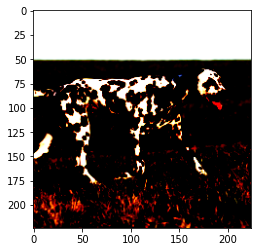

(224, 224, 3)
float32


In [86]:
# transform=ImageTranform()
# img=Image.open("images/Q17504_001.jpg")
# img=transform(img)
# img=img.numpy().transpose((1,2,0)) # pytorch用に次元入れ替え
# img=np.clip(img,0,1)
# plt.imshow(img)
# plt.show()
# print(img.shape)
# print(img.dtype)

In [ ]:
# # 実行後のファイルはすでに保存してあるのでコメントアウト

# # # image_size=32 #試し用
# # image_size=224 

# # image_shape=(image_size,image_size,3)

# # ファイルの入出力用にglobをインポート
# import glob

# image_dir = "images"
# paths=glob.glob(image_dir+"/*")

# ## 準備

# q_files = defaultdict(list)
# imgs,qids=[],[]
# transform=ImageTranform()

# for path in tqdm(paths):
#   try:
#     # img=np.array(Image.open(path).convert("RGB").resize((image_size,image_size)))
#     img=Image.open(path)
#     img=transform(img)
#     img=img.numpy().transpose((1,2,0)) # pytorch用に次元入れ替え
#     img=np.clip(img,0,1)
#   except Exception as e:
#     print(e)
#   else:
#     ## キーと画像のリストを保存
#     filename=path.split("/")[1]
#     qid = filename.split("_")[0][1:]
#     qids.append(qid)
#     imgs.append(img)
#     ## キーから画像を取得できるようにする
#     # q_files[qid].append(img)

In [88]:
# #  pickleで保存
# with open('qids.binaryfile','wb') as f:
#   pickle.dump(qids,f)

# with open('imgs.binaryfile','wb') as f:
#   pickle.dump(imgs,f)

In [89]:
# # 保存したファイルをdriveにコピー
# !cp /content/imgs.binaryfile /content/drive/MyDrive/instance_recog
# !cp /content/qids.binaryfile /content/drive/MyDrive/instance_recog

In [90]:
# 保存したファイルをdriveから取ってくる
!cp /content/drive/MyDrive/instance_recog/imgs.binaryfile .
!cp /content/drive/MyDrive/instance_recog/qids.binaryfile .

In [91]:
# pickleからロード
with open('/content/qids.binaryfile','rb') as f:
  qids=pickle.load(f)
with open('/content/imgs.binaryfile','rb') as f:
  imgs=pickle.load(f)

In [92]:
imgs.shape

AttributeError: ignored

In [93]:
qids.shape

AttributeError: ignored

In [103]:
type(qids)

list

In [104]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(qids)
y_labels=le.transform(qids)
# print(le.classes_)
# print(le.transform(qids)) 
# print(le.inverse_transform([1, 0, 2, 0]))

In [95]:
n_classes=len(set(y_labels.tolist()))

In [ ]:
# import collections
# # l = ['a', 'a', 'a', 'a', 'b', 'c', 'c']
# c = collections.Counter(qids)

In [ ]:
# c

In [ ]:
# 少なすぎる要素を一旦除去
# d=list(c.items())
# e=sorted(d,key=lambda t:t[1])
# print(e)

[(61, 7), (120, 8), (164, 10), (206, 18), (99, 22), (3, 27), (244, 28), (16, 35), (208, 37), (147, 38), (159, 41), (79, 41), (38, 42), (82, 42), (11, 43), (223, 46), (176, 46), (165, 49), (144, 50), (94, 111), (239, 154), (248, 155), (118, 159), (155, 179), (221, 191), (162, 342), (96, 361)]


In [ ]:
# !rm /content/images/Q246603_001.jpg

In [ ]:
# qids.index("246603")

In [ ]:
# del qids[59]
# del imgs[59]

In [107]:
imgs=torch.tensor(imgs,dtype=torch.float32)
y_labels=torch.from_numpy(y_labels.astype(np.uint8)).clone()

# 分割
# X_train_valid,X_test,y_train_valid,y_test=train_test_split(imgs,qids,test_size=0.2,random_state=123,shuffle=True,stratify=qids)
# X_train,X_valid,y_train,y_valid=train_test_split(X_train_valid,y_train_valid,test_size=0.2,random_state=123,shuffle=True,stratify=y_train_valid)
# X_train, X_valid, X_test = X_train/255.0, X_valid/255.0, X_test/255.0

In [41]:
import torch.utils.data

In [42]:
# 統合
dataset=torch.utils.data.TensorDataset(imgs,y_labels)
dataset

In [46]:
n_train = int(len(dataset) * 0.6)
n_val = int((len(dataset) - n_train) * 0.5)
n_test = len(dataset) - n_train - n_val

In [47]:
n_train, n_val, n_test

(1369, 456, 457)

In [48]:
# ## テストデータ1を作る
# num_test_data_1 = len(files) // 4
# random.shuffle(files)

# for filename in files[:num_test_data_1]:
#     TEST_DATA_1[filename] = True

# ## テストデータ2を作る
# for qid in tqdm(list(QIDs)):
#     data = q_files[qid]

#     if data:
#         cnt = 0
#         while cnt < 100:
#             random.shuffle(data)
#             t = data[0]
#             format = t.split(".")[-1].lower()

#             if format in ALLOW_FORMAT:
#                 break

#             cnt += 1

#         TEST_DATA_2[t] = True


# ## SAVE
# test_data_1_pickle_file = "testdata_" + CATEGORY + "_1.pickle"
# test_data_2_pickle_file = "testdata_" + CATEGORY + "_2.pickle"

# save_object(TEST_DATA_1, test_data_1_pickle_file)
# save_object(TEST_DATA_2, test_data_2_pickle_file)

In [51]:
torch.manual_seed(0)

In [52]:
train, val, test = torch.utils.data.random_split(dataset, [n_train, n_val, n_test])
# len(X_train),len(X_valid),len(X_test)

# Model

In [53]:
class TrainNet(pl.LightningModule):
  def train_dataloader(self):
    return torch.utils.data.DataLoader(train,self.batch_size,shuffle=True)
  def training_step(self,batch,batch_nb):
    x,t=batch
    y=self.forward(x)
    loss=self.lossfun(y,t)
    results={"loss":loss}
    return results

In [54]:
class ValidationNet(pl.LightningModule):
  def val_dataloader(self):
        return torch.utils.data.DataLoader(val, self.batch_size)
  def validation_step(self,batch,batch_nb):
    x,t=batch
    y=self.forward(x)
    loss=self.lossfun(y,t)
    y_label=torch.argmax(y,dim=1)
    acc=torch.sum(t==y_label)/len(t)
    results={"val_loss":loss,"val_acc":acc}
    return results
  def validation_end(self,outputs):
    avg_loss=torch.stack([x["val_loss"] for x in outputs]).mean()
    avg_acc=torch.stack([x["val_acc"] for x in outputs]).mean()
    results={"val_loss":avg_loss,"val_acc":avg_acc}
    return results

In [55]:
class TestNet(pl.LightningModule):
    def test_dataloader(self):
        return torch.utils.data.DataLoader(test, self.batch_size)

    def test_step(self, batch, batch_nb):
        x, t = batch
        y = self.forward(x)
        loss = self.lossfun(y, t)
        y_label = torch.argmax(y, dim=1)
        acc = torch.sum(t == y_label) * 1.0 / len(t)
        results = {'test_loss': loss, 'test_acc': acc}
        return results

    def test_end(self, outputs):
        avg_loss = torch.stack([x['test_loss'] for x in outputs]).mean()
        avg_acc = torch.stack([x['test_acc'] for x in outputs]).mean()
        results = {'test_loss': avg_loss, 'test_acc': avg_acc}
        return results

In [56]:
# class Net(TrainNet,ValidationNet,TestNet):
#   def __init__(self,batch_size=256):
#     super().__init__()
#     self.batch_size=batch_size
#     self.conv1=nn.Conv2d(3,64,3,padding=1)
#     self.bn1=nn.BatchNorm2d(64)
#     self.conv2=nn.Conv2d(64,128,3,padding=1)
#     self.bn2=nn.BatchNorm2d(128)
#     self.conv3=nn.Conv2d(128,256,3,padding=1)
#     self.bn3=nn.BatchNorm2d(256)
#     self.conv4=nn.Conv2d(256,512,3,padding=1)
#     self.bn4=nn.BatchNorm2d(512)
#     self.fc=nn.Linear(2048,n_classes)
#   def lossfun(self,y,t):
#     return F.cross_entropy(y,t)
#   def configure_optimizers(self):
#     return torch.optim.SGD(self.parameters(),lr=0.01)
#   def forward(self,x):
#     x=self.conv1(x)
#     x=self.bn1(x)
#     x=F.relu(x)
#     x=F.max_pool2d(x,2,2)

#     x=self.conv2(x)
#     x=self.bn2(x)
#     x=F.relu(x)
#     x=F.max_pool2d(x,2,2)

#     x=self.conv3(x)
#     x=self.bn3(x)
#     x=F.relu(x)
#     x=F.max_pool2d(x,2,2)

#     x=self.conv4(x)
#     x=self.bn4(x)
#     x=F.relu(x)
#     x=F.max_pool2d(x,2,2)

#     x=x.view(-1,2048)
#     x=self.fc(x)
    
#     return x

In [57]:
# torch.backends.cudnn.deterministic=True
# torch.backends.cudnn.benchmark=False
# torch.manual_seed(0)

# net=Net()
# trainer=Trainer(gpus=1,max_epochs=10,batch_size=1024)
# trainer.fit(net)

In [58]:
# trainer.test()
# trainer.callback_metrics

NameError: ignored

# Resnet18

In [59]:
from torchvision.models import resnet18

In [60]:
resnet=resnet18(pretrained=True)

# Dataset

In [63]:
class Net(TrainNet,ValidationNet, TestNet):
  def __init__(self,batch_size=256):
    super().__init__()
    self.batch_size=batch_size
    self.conv=resnet
    self.fc=nn.Linear(1000,n_classes)
    for param in self.conv.parameters():
      param.requires_grad=False
      
  def lossfun(self, y, t):
      return F.cross_entropy(y, t)

  def configure_optimizers(self):
      return torch.optim.SGD(self.parameters(), lr=0.01)

  def forward(self, x):
      x = self.conv(x)
      x = self.fc(x)
      return x

In [64]:
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.benchmark=False
torch.manual_seed(0)

net=Net()
trainer=Trainer(gpus=1,max_epochs=10,batch_size=1024)
trainer.fit(net)

Validation sanity check:   0%|          | 0/5 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

Validating:   0%|          | 0/2 [00:00<?, ?it/s]

1

In [65]:
trainer.test()
trainer.callback_metrics

Testing:   0%|          | 0/2 [00:00<?, ?it/s]

----------------------------------------------------------------------------------------------------
TEST RESULTS
{}
----------------------------------------------------------------------------------------------------


{'epoch': 9,
 'loss': 2.3249197006225586,
 'test_acc': 0.16660836338996887,
 'test_loss': 3.105807065963745,
 'val_acc': 0.15757812559604645,
 'val_loss': 3.1748881340026855}